# Prediction using LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta

In [ ]:
# Charger les données
df = pd.read_csv("../data/processed\cleaned_tweet_data.csv", parse_dates=['date'])

# Trier
df = df.sort_values(by=['tweet_id', 'date'])

df

,tweet_id,company,date,username,text,replies,reposts,likes,bookmarks,views,comment_count,total_engagement,main_sentiment,avg_comment_sentiment
6,1878804210986479685,samsung,2025-04-10,SamsungMobile,samsung leads sleep technology with expansion ...,33,74,559,16,63357,10,682,0.0,0.156278
14,1878804210986479685,samsung,2025-04-11,SamsungMobile,samsung leads sleep technology with expansion ...,33,74,559,16,63368,10,682,0.0,0.156278
22,1878804210986479685,samsung,2025-04-12,SamsungMobile,samsung leads sleep technology with expansion ...,33,75,561,16,63390,10,685,0.0,0.156278
30,1878804210986479685,samsung,2025-04-13,SamsungMobile,samsung leads sleep technology with expansion ...,33,75,561,16,63395,10,685,0.0,0.173642
38,1878804210986479685,samsung,2025-04-14,SamsungMobile,samsung leads sleep technology with expansion ...,33,75,560,16,63417,10,684,0.0,0.173642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1909687808060711266,apple,2025-04-14,theapplehub,president trump believes apple could manufactu...,371,219,2777,149,329714,223,3516,0.0,0.077130
193,1909687808060711266,apple,2025-04-15,theapplehub,president trump believes apple could manufactu...,370,220,2782,149,331930,386,3521,0.0,0.080990
213,1909687808060711266,apple,2025-04-16,theapplehub,president trump believes apple could manufactu...,370,218,2785,150,333589,375,3523,0.0,0.067975
233,1909687808060711266,apple,2025-04-17,theapplehub,president trump believes apple could manufactu...,370,219,2789,151,335032,301,3529,0.0,0.063355


In [46]:
window_size = 6  # nombre de jours précédents pour la prédiction
horizon = 1      # prédire le jour suivant

all_sequences = []
tweet_ids = []

# Normalisation
scalers = {}

for tweet_id, group in df.groupby('tweet_id'):
    group = group.sort_values('date')
    if len(group) < window_size + horizon:
        continue  # skip short sequences

    values = group['total_engagement'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values)
    scalers[tweet_id] = scaler

    for i in range(len(scaled_values) - window_size - horizon + 1):
        input_seq = scaled_values[i:i+window_size]
        target = scaled_values[i+window_size+horizon-1]
        all_sequences.append((input_seq, target))
        tweet_ids.append(tweet_id)

# Séparation X, y
X = np.array([seq[0] for seq in all_sequences])
y = np.array([seq[1] for seq in all_sequences])

In [47]:
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


c:\Users\perso\Desktop\MLOPS\github_projet\Twitter_Trend_Tracking_MLOps\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.6043 - val_loss: 0.6685
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4849 - val_loss: 0.4968
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3588 - val_loss: 0.3385
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2743 - val_loss: 0.1980
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1748 - val_loss: 0.0864
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1211 - val_loss: 0.0206
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0805 - val_loss: 0.0143
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0986 - val_loss: 0.0321
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1157 - val_loss: 0.0268
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0999 - val_loss: 0.0126


In [48]:
def forecast_future(tweet_id, df, model, scaler, window_size=5, days_ahead=5):
    tweet_df = df[df['tweet_id'] == tweet_id].sort_values('date')
    last_values = tweet_df['total_engagement'].values[-window_size:]
    
    # Normaliser
    input_seq = scaler.transform(last_values.reshape(-1, 1)).reshape(1, window_size, 1)
    predictions = []

    for _ in range(days_ahead):
        pred = model.predict(input_seq)[0][0]
        predictions.append(pred)
        input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    start_date = tweet_df['date'].max() + timedelta(days=1)
    future_dates = [start_date + timedelta(days=i) for i in range(days_ahead)]

    return pd.DataFrame({'date': future_dates, 'forecast': predictions})

In [49]:
def plot_forecast(tweet_id, df, forecast_df):
    true_df = df[df['tweet_id'] == tweet_id].sort_values('date')
    
    plt.figure(figsize=(10, 5))
    plt.plot(true_df['date'], true_df['total_engagement'], label='Historique', marker='o')
    plt.plot(forecast_df['date'], forecast_df['forecast'], label='Prévision', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Total Engagement')
    plt.title(f'Prévision pour Tweet ID {tweet_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


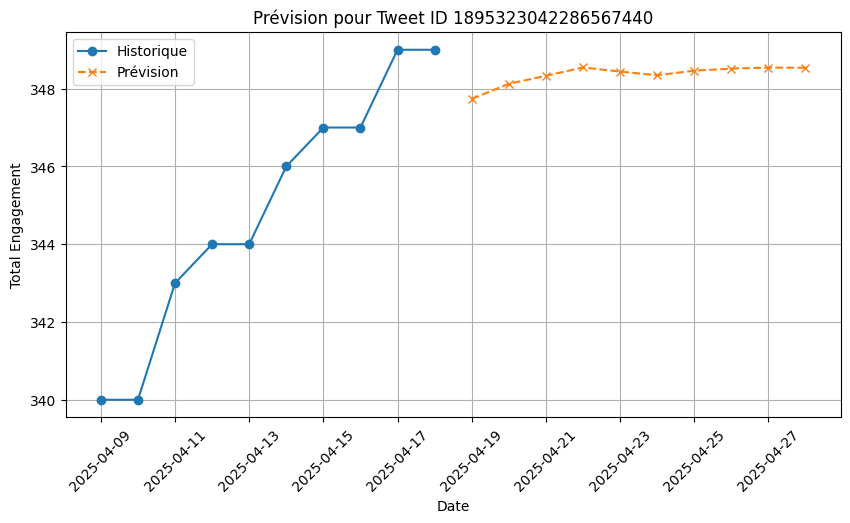

In [50]:
# --- 10. Visualize Predictions ---
tweet_exemple = df['tweet_id'].value_counts().idxmax()
forecast_df = forecast_future(tweet_exemple, df, model, scalers[tweet_exemple],days_ahead=10)
plot_forecast(tweet_exemple, df, forecast_df)


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import numpy as np

def evaluate_lstm(df, model, scalers, window_size=6, horizon=1):
    maes, rmses, r2s = [], [], []
    tweet_ids = []
    for tweet_id, group in df.groupby('tweet_id'):
        group = group.sort_values('date')
        if len(group) < window_size + horizon:
            continue
        scaler = scalers[tweet_id]
        values = group['total_engagement'].values
        scaled = scaler.transform(values.reshape(-1, 1)).flatten()
        preds, trues = [], []
        for i in range(window_size, len(scaled) - horizon + 1):
            input_seq = scaled[i-window_size:i].reshape(1, window_size, 1)
            true_val = values[i + horizon - 1]
            pred_scaled = model.predict(input_seq, verbose=0)[0][0]
            pred = scaler.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)
            trues.append(true_val)
        # Only compute metrics if at least 2 samples
        if len(trues) > 1:
            preds = np.array(preds).astype(int)
            trues = np.array(trues).astype(int)
            maes.append(mean_absolute_error(trues, preds))
            rmses.append(math.sqrt(mean_squared_error(trues, preds)))
            r2s.append(r2_score(trues, preds))
            tweet_ids.append(tweet_id)
    # Remove nan values from r2s
    r2s = [r for r in r2s if not np.isnan(r)]
    print(f"Average MAE: {np.mean(maes):.2f} ± {np.std(maes):.2f}")
    print(f"Average RMSE: {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
    print(f"Average R²: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    return tweet_ids, maes, rmses, r2s

tweet_ids, maes, rmses, r2s = evaluate_lstm(df, model, scalers, window_size=window_size, horizon=1)

Average MAE: 13.25 ± 15.50
Average RMSE: 14.98 ± 16.61
Average R²: -164.2332 ± 458.1709


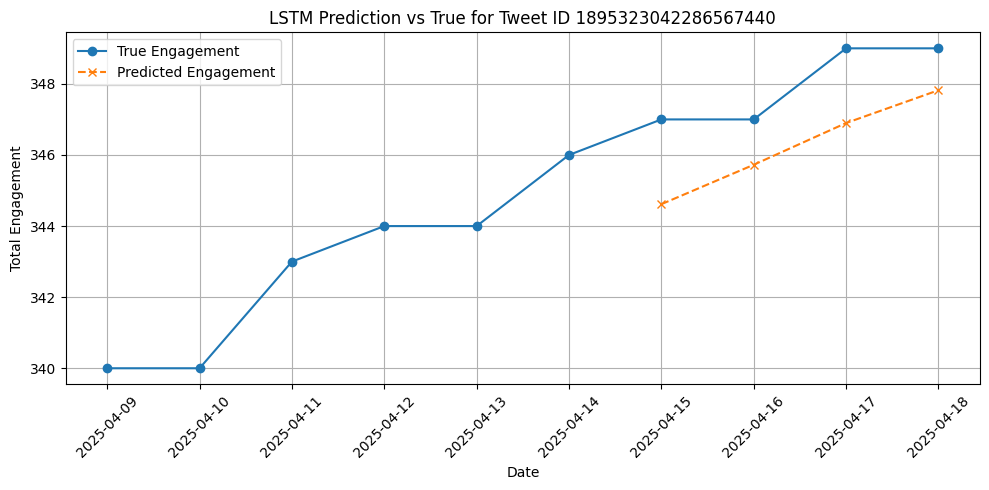

In [55]:
def plot_lstm_predictions(tweet_id, df, model, scaler, window_size=6, horizon=1):
    group = df[df['tweet_id'] == tweet_id].sort_values('date')
    values = group['total_engagement'].values
    dates = group['date'].values
    scaled = scaler.transform(values.reshape(-1, 1)).flatten()
    preds, trues, pred_dates = [], [], []
    for i in range(window_size, len(scaled) - horizon + 1):
        input_seq = scaled[i-window_size:i].reshape(1, window_size, 1)
        true_val = values[i + horizon - 1]
        pred_scaled = model.predict(input_seq, verbose=0)[0][0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]
        preds.append(pred)
        trues.append(true_val)
        pred_dates.append(dates[i + horizon - 1])
    plt.figure(figsize=(10,5))
    plt.plot(dates, values, label='True Engagement', marker='o')
    plt.plot(pred_dates, preds, label='Predicted Engagement', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Total Engagement')
    plt.title(f'LSTM Prediction vs True for Tweet ID {tweet_id}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
#tweet_id_to_plot = tweet_ids[0]  # or set to any tweet_id you want
tweet_id_to_plot = df['tweet_id'].value_counts().idxmax()  # Most frequent tweet_id
plot_lstm_predictions(tweet_id_to_plot, df, model, scalers[tweet_id_to_plot], window_size=window_size, horizon=1)

# Prediction using RandomForestRegressor

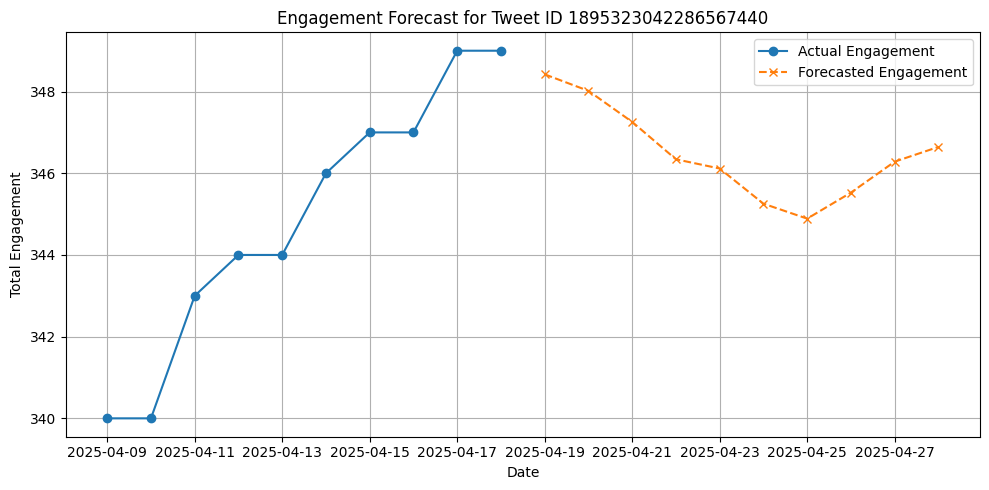

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

# === 1. Load and preprocess data ==
df = pd.read_csv("../data/processed\cleaned_tweet_data.csv", parse_dates=['date'])
df = df.sort_values(by=['tweet_id', 'date'])

# Keep only relevant columns
df = df[['tweet_id', 'date', 'total_engagement']]

# Hyperparameters
window_size = 5
horizon = 1

X, y = [],[]
tweet_ids = []
scalers = {}

# === 2. Generate training sequences ===
for tweet_id, group in df.groupby('tweet_id'):
    group = group.sort_values('date')
    if len(group) < window_size + horizon:
        continue

    scaler = MinMaxScaler()
    values = group['total_engagement'].values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    scalers[tweet_id] = scaler

    for i in range(len(scaled) - window_size - horizon + 1):
        X.append(scaled[i:i+window_size].flatten())
        y.append(scaled[i+window_size+horizon-1])
        tweet_ids.append(tweet_id)

X = np.array(X)
y = np.array(y)

# === 3. Train Random Forest model ===
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y.ravel())
# === 4. Forecast future engagement ===
def forecast_future(tweet_id, df, model, scaler, window_size=5, days_ahead=5):
    tweet_df = df[df['tweet_id'] == tweet_id].sort_values('date')
    last_values = tweet_df['total_engagement'].values[-window_size:]
    
    if len(last_values) < window_size:
        print("Not enough data to forecast for this tweet.")
        return None
    
    input_seq = scaler.transform(last_values.reshape(-1, 1)).flatten()
    predictions = []

    for _ in range(days_ahead):
        pred_scaled = model.predict([input_seq])[0]
        predictions.append(pred_scaled)
        input_seq = np.append(input_seq[1:], pred_scaled)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    start_date = tweet_df['date'].max() + timedelta(days=1)
    future_dates = [start_date + timedelta(days=i) for i in range(days_ahead)]

    return pd.DataFrame({'date': future_dates, 'forecast': predictions})

# === 5. Plot forecast === 
def plot_forecast(tweet_id, df, forecast_df):
    true_df = df[df['tweet_id'] == tweet_id].sort_values('date')

    plt.figure(figsize=(10, 5))
    plt.plot(true_df['date'], true_df['total_engagement'], label='Actual Engagement', marker='o')
    
    if forecast_df is not None:
        plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecasted Engagement', linestyle='--', marker='x')
    
    plt.title(f'Engagement Forecast for Tweet ID {tweet_id}')
    plt.xlabel('Date')
    plt.ylabel('Total Engagement')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 6. Example usage ===
# Choose a tweet_id with enough data
selected_tweet_id = df['tweet_id'].value_counts().idxmax()

# Forecast
forecast_df = forecast_future(selected_tweet_id, df, model, scalers[selected_tweet_id],days_ahead=10)

# Plot
plot_forecast(selected_tweet_id, df, forecast_df)


In [57]:
# === 7. Evaluate Random Forest model ===
def evaluate_rf(df, model, scalers, window_size=5, horizon=1):
    maes, rmses, r2s = [], [], []
    tweet_ids = []
    
    for tweet_id, group in df.groupby('tweet_id'):
        group = group.sort_values('date')
        if len(group) < window_size + horizon:
            continue
        
        scaler = scalers[tweet_id]
        values = group['total_engagement'].values
        scaled = scaler.transform(values.reshape(-1, 1)).flatten()
        
        preds, trues = [], []
        
        for i in range(window_size, len(scaled) - horizon + 1):
            input_seq = scaled[i-window_size:i].flatten()
            true_val = values[i + horizon - 1]
            pred_scaled = model.predict([input_seq])[0]
            pred = scaler.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)
            trues.append(true_val)
        
        if len(trues) > 1:
            maes.append(mean_absolute_error(trues, preds))
            rmses.append(math.sqrt(mean_squared_error(trues, preds)))
            r2s.append(r2_score(trues, preds))
            tweet_ids.append(tweet_id)
    
    print(f"Average MAE: {np.mean(maes):.2f} ± {np.std(maes):.2f}")
    print(f"Average RMSE: {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
    print(f"Average R²: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    
    return tweet_ids, maes, rmses, r2s
tweet_ids_rf, maes_rf, rmses_rf, r2s_rf = evaluate_rf(df, model, scalers, window_size=window_size, horizon=1)

Average MAE: 1.57 ± 1.69
Average RMSE: 1.79 ± 1.84
Average R²: -1.9192 ± 10.0343


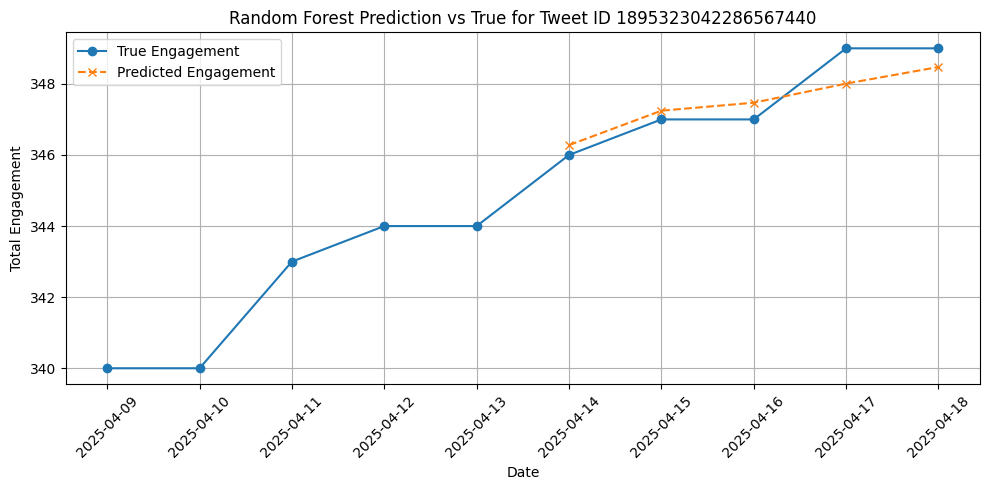

In [58]:
def plot_rf_predictions(tweet_id, df, model, scaler, window_size=5, horizon=1):
    group = df[df['tweet_id'] == tweet_id].sort_values('date')
    values = group['total_engagement'].values
    dates = group['date'].values
    scaled = scaler.transform(values.reshape(-1, 1)).flatten()
    
    preds, trues, pred_dates = [], [], []
    
    for i in range(window_size, len(scaled) - horizon + 1):
        input_seq = scaled[i-window_size:i].flatten()
        true_val = values[i + horizon - 1]
        pred_scaled = model.predict([input_seq])[0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]
        preds.append(pred)
        trues.append(true_val)
        pred_dates.append(dates[i + horizon - 1])
    
    plt.figure(figsize=(10,5))
    plt.plot(dates, values, label='True Engagement', marker='o')
    plt.plot(pred_dates, preds, label='Predicted Engagement', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Total Engagement')
    plt.title(f'Random Forest Prediction vs True for Tweet ID {tweet_id}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
#tweet_id_to_plot_rf = tweet_ids_rf[2]  # or set to any tweet_id you want
tweet_id_to_plot_rf = df['tweet_id'].value_counts().idxmax()  # or set to any tweet_id you want
plot_rf_predictions(tweet_id_to_plot_rf, df, model, scalers[tweet_id_to_plot_rf], window_size=window_size, horizon=1)

# With XGBRegressor

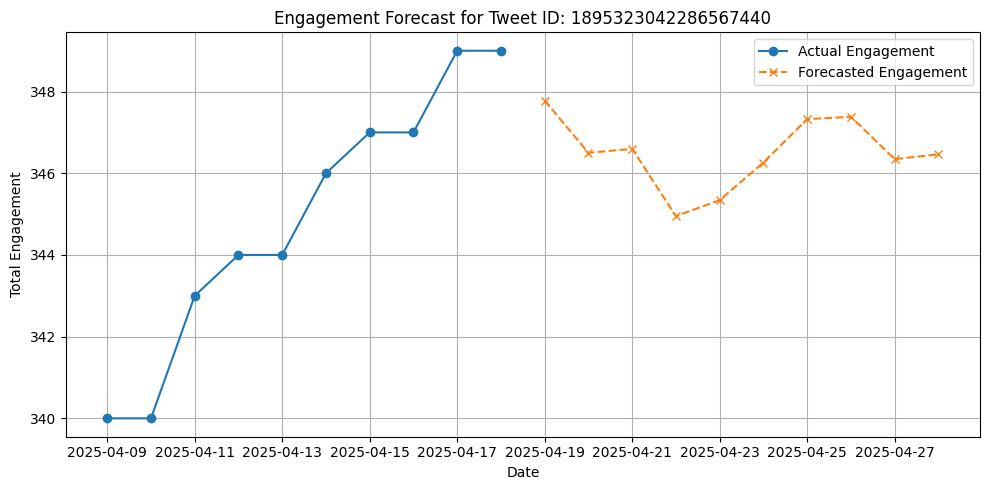

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

# === 1. Load and preprocess data ==
df = pd.read_csv("../data/processed\cleaned_tweet_data.csv", parse_dates=['date'])
df = df.sort_values(by=['tweet_id', 'date'])

# Keep only relevant columns
df = df[['tweet_id', 'date', 'total_engagement']]

window_size = 5  # Number of days to look back
horizon = 1      # Days ahead to predict

X, y = [], []
scalers = {}

# For each tweet
for tweet_id, group in df.groupby("tweet_id"):
    group = group.sort_values("date")
    if len(group) < window_size + horizon:
        continue

    scaler = MinMaxScaler()
    values = group["total_engagement"].values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    scalers[tweet_id] = scaler

    for i in range(len(scaled) - window_size - horizon + 1):
        X.append(scaled[i:i+window_size].flatten())
        y.append(scaled[i+window_size+horizon-1][0])

X = np.array(X)
y = np.array(y)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

def forecast_xgboost(tweet_id, df, model, scaler, window_size=5, days_ahead=5):
    tweet_df = df[df["tweet_id"] == tweet_id].sort_values("date")
    last_values = tweet_df["total_engagement"].values[-window_size:]
    
    if len(last_values) < window_size:
        print(f"Not enough data for tweet_id {tweet_id}")
        return None

    input_seq = scaler.transform(last_values.reshape(-1, 1)).flatten()
    predictions = []

    for _ in range(days_ahead):
        pred_scaled = model.predict([input_seq])[0]
        predictions.append(pred_scaled)
        input_seq = np.append(input_seq[1:], pred_scaled)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    start_date = tweet_df["date"].max() + timedelta(days=1)
    future_dates = [start_date + timedelta(days=i) for i in range(days_ahead)]

    return pd.DataFrame({"date": future_dates, "forecast": predictions})

def plot_forecast(tweet_id, df, forecast_df):
    actual_df = df[df["tweet_id"] == tweet_id].sort_values("date")

    plt.figure(figsize=(10, 5))
    plt.plot(actual_df["date"], actual_df["total_engagement"], label="Actual Engagement", marker='o')
    
    if forecast_df is not None:
        plt.plot(forecast_df["date"], forecast_df["forecast"], label="Forecasted Engagement", linestyle='--', marker='x')
    
    plt.title(f"Engagement Forecast for Tweet ID: {tweet_id}")
    plt.xlabel("Date")
    plt.ylabel("Total Engagement")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Choose a tweet with enough data
tweet_counts = df["tweet_id"].value_counts()
selected_tweet_id = tweet_counts[tweet_counts >= window_size + 1].index[0]

forecast_df = forecast_xgboost(selected_tweet_id, df, model, scalers[selected_tweet_id], days_ahead=10)
plot_forecast(selected_tweet_id, df, forecast_df)




In [61]:
# === 7. Evaluate xgboost model ===
def evaluate_xgboost(df, model, scalers, window_size=5, horizon=1):
    maes, rmses, r2s = [], [], []
    tweet_ids = []
    
    for tweet_id, group in df.groupby("tweet_id"):
        group = group.sort_values("date")
        if len(group) < window_size + horizon:
            continue
        
        scaler = scalers[tweet_id]
        values = group["total_engagement"].values
        scaled = scaler.transform(values.reshape(-1, 1)).flatten()
        
        preds, trues = [], []
        
        for i in range(window_size, len(scaled) - horizon + 1):
            input_seq = scaled[i-window_size:i].flatten()
            true_val = values[i + horizon - 1]
            pred_scaled = model.predict([input_seq])[0]
            pred = scaler.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)
            trues.append(true_val)
        
        if len(trues) > 1:
            maes.append(mean_absolute_error(trues, preds))
            rmses.append(math.sqrt(mean_squared_error(trues, preds)))
            r2s.append(r2_score(trues, preds))
            tweet_ids.append(tweet_id)
    
    print(f"Average MAE: {np.mean(maes):.2f} ± {np.std(maes):.2f}")
    print(f"Average RMSE: {np.mean(rmses):.2f} ± {np.std(rmses):.2f}")
    print(f"Average R²: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    
    return tweet_ids, maes, rmses, r2s

tweet_ids_xgb, maes_xgb, rmses_xgb, r2s_xgb = evaluate_xgboost(df, model, scalers, window_size=window_size, horizon=1)

Average MAE: 0.11 ± 0.16
Average RMSE: 0.14 ± 0.22
Average R²: 0.9949 ± 0.0118


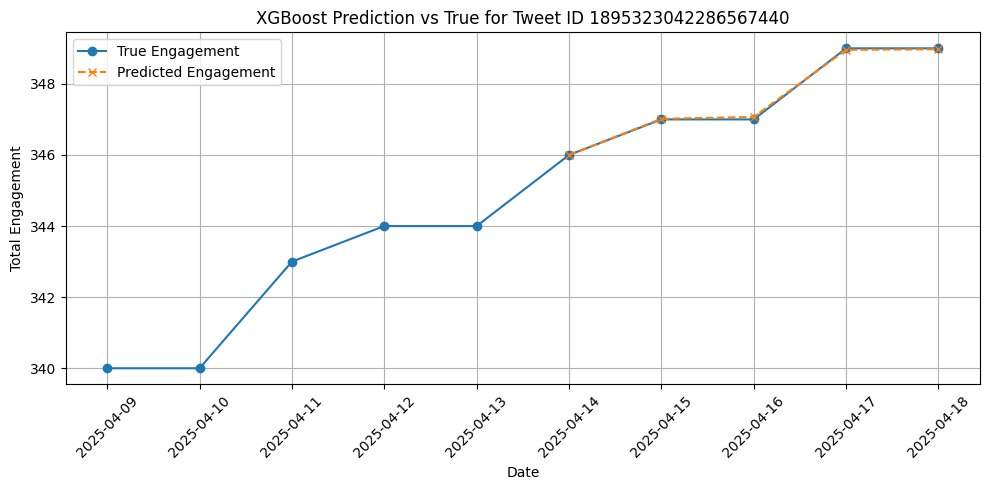

In [62]:
def plot_xgboost_predictions(tweet_id, df, model, scaler, window_size=5, horizon=1):
    group = df[df["tweet_id"] == tweet_id].sort_values("date")
    values = group["total_engagement"].values
    dates = group["date"].values
    scaled = scaler.transform(values.reshape(-1, 1)).flatten()
    
    preds, trues, pred_dates = [], [], []
    
    for i in range(window_size, len(scaled) - horizon + 1):
        input_seq = scaled[i-window_size:i].flatten()
        true_val = values[i + horizon - 1]
        pred_scaled = model.predict([input_seq])[0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]
        preds.append(pred)
        trues.append(true_val)
        pred_dates.append(dates[i + horizon - 1])
    
    plt.figure(figsize=(10,5))
    plt.plot(dates, values, label='True Engagement', marker='o')
    plt.plot(pred_dates, preds, label='Predicted Engagement', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Total Engagement')
    plt.title(f'XGBoost Prediction vs True for Tweet ID {tweet_id}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
tweet_id_to_plot_xgb = df['tweet_id'].value_counts().idxmax()  # Most frequent tweet_id
plot_xgboost_predictions(tweet_id_to_plot_xgb, df, model, scalers[tweet_id_to_plot_xgb], window_size=window_size, horizon=1)

# XGBRegressor with text embeding

Encoding tweet text using Sentence Transformers...


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


✅ Model Evaluation on Test Tweets
Average MAE: 0.17 ± 0.28
Average RMSE: 0.21 ± 0.35
Average R² Score: 0.8252 ± 0.3508
Number of evaluated tweets: 20


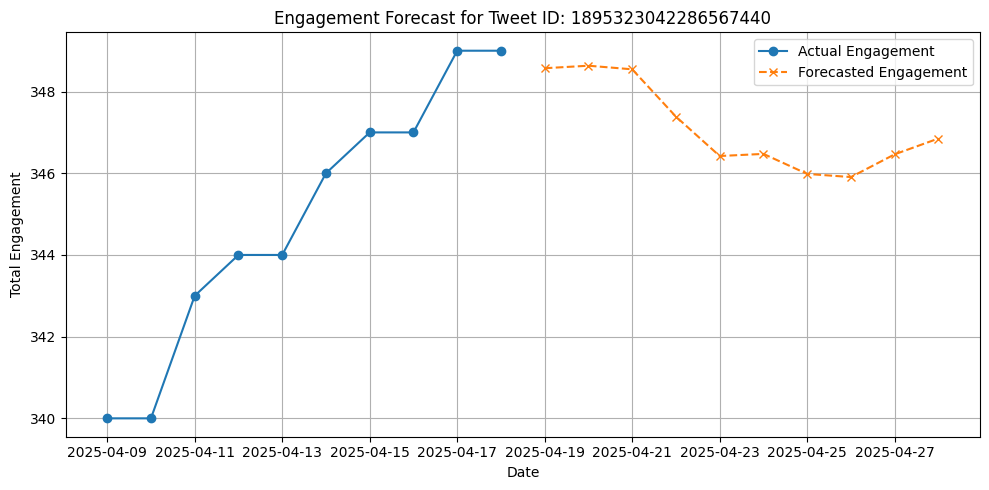

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from datetime import timedelta


# Load dataset
df = pd.read_csv("../data/processed\cleaned_tweet_data.csv", parse_dates=["date"])
df = df.sort_values(by=["tweet_id", "date"])

# Keep only relevant columns
df = df[["tweet_id", "date", "text", "total_engagement"]]

print("Encoding tweet text using Sentence Transformers...")
text_model = SentenceTransformer('all-MiniLM-L6-v2')
unique_tweets = df.drop_duplicates(subset="tweet_id")[["tweet_id", "text"]]
tweet_embeddings = text_model.encode(unique_tweets["text"].tolist(), show_progress_bar=True)

# Map tweet_id to embedding
embedding_map = {
    tweet_id: emb for tweet_id, emb in zip(unique_tweets["tweet_id"], tweet_embeddings)
}

window_size = 5
horizon = 1

X, y = [],[]
scalers = {}

for tweet_id, group in df.groupby("tweet_id"):
    group = group.sort_values("date")
    if len(group) < window_size + horizon:
        continue

    scaler = MinMaxScaler()
    values = group["total_engagement"].values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    scalers[tweet_id] = scaler

    text_emb = embedding_map[tweet_id]

    for i in range(len(scaled) - window_size - horizon + 1):
        time_features = scaled[i:i+window_size].flatten()
        combined_features = np.concatenate([time_features, text_emb])
        X.append(combined_features)
        y.append(scaled[i+window_size+horizon-1][0])

X = np.array(X)
y = np.array(y)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

def forecast_xgboost(tweet_id, df, model, scaler, embedding_map, window_size=5, days_ahead=5):
    tweet_df = df[df["tweet_id"] == tweet_id].sort_values("date")
    last_values = tweet_df["total_engagement"].values[-window_size:]

    if len(last_values) < window_size:
        print(f"Not enough data for tweet_id {tweet_id}")
        return None

    input_seq = scaler.transform(last_values.reshape(-1, 1)).flatten()
    text_emb = embedding_map[tweet_id]
    predictions = []

    for _ in range(days_ahead):
        input_features = np.concatenate([input_seq, text_emb])
        pred_scaled = model.predict([input_features])[0]
        predictions.append(pred_scaled)
        input_seq = np.append(input_seq[1:], pred_scaled)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    start_date = tweet_df["date"].max() + timedelta(days=1)
    future_dates = [start_date + timedelta(days=i) for i in range(days_ahead)]

    return pd.DataFrame({"date": future_dates, "forecast": predictions})

# Evaluate and plot the forecast
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

def evaluate_model(df, model, embedding_map, scalers, window_size=5, horizon=1):
    mae_list, rmse_list, r2_list = [], [], []

    for tweet_id, group in df.groupby("tweet_id"):
        group = group.sort_values("date")
        if len(group) < window_size + horizon + 1:
            continue

        scaler = scalers.get(tweet_id)
        if scaler is None:
            continue

        values = group["total_engagement"].values
        scaled = scaler.transform(values.reshape(-1, 1)).flatten()

        text_emb = embedding_map[tweet_id]

        input_seq = scaled[-(window_size + horizon):-horizon]
        true_seq = values[-horizon:]  # Ground truth (unscaled)

        preds = []

        for _ in range(horizon):
            input_features = np.concatenate([input_seq, text_emb])
            pred_scaled = model.predict([input_features])[0]
            pred = scaler.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)
            input_seq = np.append(input_seq[1:], pred_scaled)

        mae = mean_absolute_error(true_seq, preds)
        rmse = math.sqrt(mean_squared_error(true_seq, preds))
        r2 = r2_score(true_seq, preds)

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        
        # Dealing with NaN values in R²
        if np.isnan(r2):
            r2_list[-1] = 0.0

    return {
        "MAE_mean": np.mean(mae_list),
        "RMSE_mean": np.mean(rmse_list),
        "R2_mean": np.mean(r2_list),
        "MAE_std": np.std(mae_list),
        "RMSE_std": np.std(rmse_list),
        "R2_std": np.std(r2_list),
        "n_evaluated_tweets": len(mae_list)
    }


results = evaluate_model(df, model, embedding_map, scalers, window_size=5, horizon=2)

print("✅ Model Evaluation on Test Tweets")
print(f"Average MAE: {results['MAE_mean']:.2f} ± {results['MAE_std']:.2f}")
print(f"Average RMSE: {results['RMSE_mean']:.2f} ± {results['RMSE_std']:.2f}")
print(f"Average R² Score: {results['R2_mean']:.4f} ± {results['R2_std']:.4f}")
print(f"Number of evaluated tweets: {results['n_evaluated_tweets']}")


def plot_forecast(tweet_id, df, forecast_df):
    actual_df = df[df["tweet_id"] == tweet_id].sort_values("date")

    plt.figure(figsize=(10, 5))
    plt.plot(actual_df["date"], actual_df["total_engagement"], label="Actual Engagement", marker='o')
    
    if forecast_df is not None:
        plt.plot(forecast_df["date"], forecast_df["forecast"], label="Forecasted Engagement", linestyle='--', marker='x')
    
    plt.title(f"Engagement Forecast for Tweet ID: {tweet_id}")
    plt.xlabel("Date")
    plt.ylabel("Total Engagement")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Pick a tweet with enough data
tweet_counts = df["tweet_id"].value_counts()
selected_tweet_id = tweet_counts[tweet_counts >= window_size + 1].index[0]

forecast_df = forecast_xgboost(selected_tweet_id, df, model, scalers[selected_tweet_id], embedding_map, days_ahead=10)
plot_forecast(selected_tweet_id, df, forecast_df)



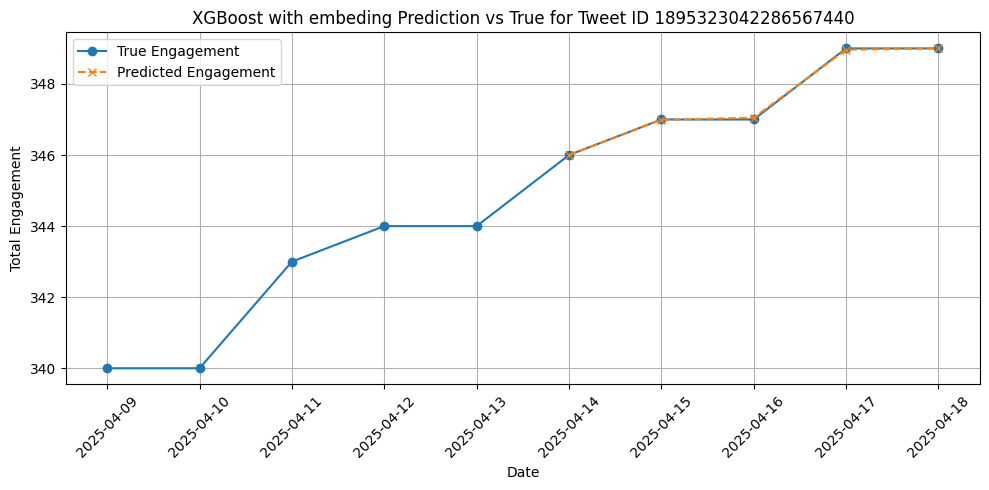

In [69]:
def plot_predictions(tweet_id, df, model, scaler, embedding_map, window_size=5, horizon=1):
    group = df[df["tweet_id"] == tweet_id].sort_values("date")
    values = group["total_engagement"].values
    dates = group["date"].values
    scaled = scaler.transform(values.reshape(-1, 1)).flatten()
    
    preds, trues, pred_dates = [], [], []
    
    for i in range(window_size, len(scaled) - horizon + 1):
        input_seq = scaled[i-window_size:i].flatten()
        text_emb = embedding_map[tweet_id]
        input_features = np.concatenate([input_seq, text_emb])
        
        true_val = values[i + horizon - 1]
        pred_scaled = model.predict([input_features])[0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]
        
        preds.append(pred)
        trues.append(true_val)
        pred_dates.append(dates[i + horizon - 1])
    
    plt.figure(figsize=(10,5))
    plt.plot(dates, values, label='True Engagement', marker='o')
    plt.plot(pred_dates, preds, label='Predicted Engagement', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Total Engagement')
    plt.title(f'XGBoost with embeding Prediction vs True for Tweet ID {tweet_id}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
tweet_id_to_plot_xgb = df['tweet_id'].value_counts().idxmax()  # Most frequent tweet_id
plot_predictions(tweet_id_to_plot_xgb, df, model, scalers[tweet_id_to_plot_xgb], embedding_map, window_size=window_size, horizon=1)